# Chapter 3 - AutoGluon Text Classification

[AutoGluon](https://auto.gluon.ai/stable/index.html) an open source AutoML library by [Amazon](https://www.amazon.science/amazons-autogluon-helps-developers-get-up-and-running-with-state-of-the-art-deep-learning-models-with-just-a-few-lines-of-code) that automates deep learning applications for image, text, or tabular datasets. This sample notebook presents a multiclass text classification example using the [Amazon Customer Reviews](https://doi.org/10.7910/DVN/W96OFO) dataset and AutoGluon Text Predictor. 

You can experiment with this example on [Amazon SageMaker Studio Lab](https://aws.amazon.com/sagemaker/studio-lab/), a free ML development environment that provides up to 12 hours of CPU or 4 hours of GPU per user session and 15GiB storage at no cost. Alternatively, you can try this on your preferred Integrated Development Environment (IDE).

## Setup

Install and load essential libraries

In [2]:
# Install required packages

import sys
!{sys.executable} -m pip install -qr requirements.txt

You should consider upgrading via the '/usr/local/bin/python -m pip install --upgrade pip' command.


In [3]:
# Load essential libraries

%matplotlib inline

import numpy as np
import warnings
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
from platform import python_version
from autogluon.tabular.version import __version__

warnings.filterwarnings('ignore')
np.random.seed(42)

print(f'TensorFlow version: {tf.__version__}')
print(f'Python version: {python_version()}')
print(f'AutoGluon version: {__version__}')

TensorFlow version: 2.9.0
Python version: 3.8.2
AutoGluon version: 0.6.1


## Prepare the Data
Load the Amazon Customer Review dataset (export_food.csv). We will use **reviews** and **ratings** columns for this example.

In [4]:
# Display full text

pd.set_option("display.max_colwidth", None)

In [5]:
# Load the raw dataset. Remove any leading and trailing characters.

df = pd.read_csv('export_food.csv')
data = df[['reviews','ratings']]
data['reviews'] = data['reviews'].str.strip()
data.head(3)

,reviews,ratings
0,"I’ve been ordering this product monthly for over a year. These past few shipments have been off, and the packaging is different. It is obvious they are from two different manufacturers. The full bottle is the imposter and has no pink ribbon on the label, the label photo is different, and if you look at the bottle, you can see on the back that the legitimate product has a 3% Juice Content label on the back up top, and the imposter has a 1% Juice Content. There are also other differences on the label. See Photos for comparison. Two different products, and the IMPOSTER is absolutely undrinkable and tastes nothing like the original product.I contacted Amazon and they are pulling this flavor, Red Grapefruit, off the shelf while they investigate this issue. They also issued me a full credit. I hope they can get this figured out because this is my favorite flavor and I drink it everyday.",4
1,"I used to drink these Sparkling Ice waters in all flavors every day. They all taste GREAT, my favorite was Black Raspberry. However, I just discovered that they contain sucralose which is just another harmful artificial sweetener. The only safe sweeteners are Stevia, Agave, and Raw Honey. I have stopped drinking/eating anything with harmful artificial sweeteners since they have been linked to many diseases, including dementia and the increase in Atzheimers disease patients.",5
2,"Update March 2019: I have been a regular subscriber of 3 cases a month of Sparkling Ice for a few years. I LOVED the stuff. It was plenty diabetic/keto-friendly with its 3% real juice and it tasted not merelt great, but REALISTIC. Then, sometime in the last year or so, I just stopped wanting to drink it as much. The flavor was no longer exciting. The mock mulled cider I made with it this Christmas fell flat. I thought I’d just lost my taste for it until I saw that another reviewer had noticed that the juice content went from 3% to 1%. I looked at my bottles and all the flavors indeed now say 1% juice.The company said it was to conform to its zero-sugar claim but I don’t believe it - 3% of 179mL (one serving) would be about 5g of juice, which would contain about half a gram of sugar, which can legally be labeled as 0 grams. They could have replaced the aromatics and maintained the flavor but that would probably have been more expensive than just using real juice.Now these drinks taste about the same as any other diet soda. The flavors are now flat instead of complex and realistic like they used to be.I AM CANCELLING MY SUBSCRIPTION FOR ALL THREE CASES PER MONTH. ARE YOU LISTENING, TALKING RAIN INC?I also intend to complain to Amazon about allowing Sparkling Ice to keep its past high ratings for what is no longer the same product. It is very misleading if reviews don’t all refer to the same thing being reviewed.Old review: Crisp Apple Sparkling Ice tastes almost exactly like Martinelli's sparkling ciderBeing on a carb-restricted diet, one of the things I miss most is the taste of fruit, and especially the intense flavor of fruit juices. To my palate (accustomed as it is to most artificial sweeteners), Crisp Apple Sparkling Ice tastes almost exactly like Martinelli's sparkling cider.Crisp Apple, Coconut Pineapple, and Pink Grapefruit are in my opinion, the most realistic flavors of Sparkling Ice.At $1 a bottle, it's not quite cheap but it is an affordable treat.Update: at Christmastime, I used Crisp Apple as a base for zero-carb mulled “cider.” Lacking proper mulling spices, a Constant Comment tea bag with its cinnamon/orange peel/clove flavoring did the trick nicely. A touch of malic acid restored the tanginess lost from heating the fizz (carbonic acid) out of it.",1


In [6]:
# View dataset information, including index dtype, columns, non-null values, and memory usage.

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   reviews  5000 non-null   object
 1   ratings  5000 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 78.2+ KB


In [7]:
# Unique classes
data['ratings'].unique()

array([4, 5, 1, 2, 3])

In [8]:
# Class frequency distribution
data['ratings'].value_counts()

5    3402
4     683
1     677
3     134
2     104
Name: ratings, dtype: int64

<AxesSubplot:>

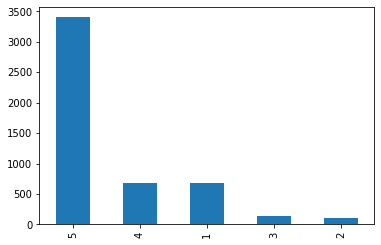

In [9]:
# Visualize class distribution
data['ratings'].value_counts().plot(kind = 'bar')

The original dataset is highly imbalanced. We will use RandomOverSampler to duplicate examples randomly in the minority class.

In [10]:
from imblearn.over_sampling import RandomOverSampler

X = data[['reviews']]
y = data[['ratings']]

ros = RandomOverSampler(sampling_strategy='minority')
X_res, y_res = ros.fit_resample(X, y)

RandomOverSampler(sampling_strategy='minority')

RandomOverSampler(sampling_strategy='minority')

<AxesSubplot:xlabel='ratings'>

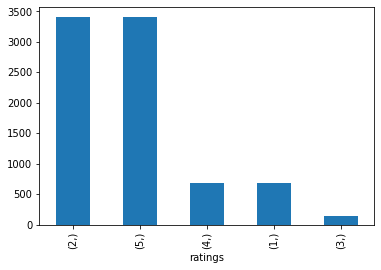

In [11]:
# Visualize the frequency distribution after oversampling

y_res.value_counts().plot(kind = 'bar')

In [12]:
# Merge the rebalanced dataset

rebalanced_data = X_res.join(y_res)
rebalanced_data.head(3)

,reviews,ratings
0,"I’ve been ordering this product monthly for over a year. These past few shipments have been off, and the packaging is different. It is obvious they are from two different manufacturers. The full bottle is the imposter and has no pink ribbon on the label, the label photo is different, and if you look at the bottle, you can see on the back that the legitimate product has a 3% Juice Content label on the back up top, and the imposter has a 1% Juice Content. There are also other differences on the label. See Photos for comparison. Two different products, and the IMPOSTER is absolutely undrinkable and tastes nothing like the original product.I contacted Amazon and they are pulling this flavor, Red Grapefruit, off the shelf while they investigate this issue. They also issued me a full credit. I hope they can get this figured out because this is my favorite flavor and I drink it everyday.",4
1,"I used to drink these Sparkling Ice waters in all flavors every day. They all taste GREAT, my favorite was Black Raspberry. However, I just discovered that they contain sucralose which is just another harmful artificial sweetener. The only safe sweeteners are Stevia, Agave, and Raw Honey. I have stopped drinking/eating anything with harmful artificial sweeteners since they have been linked to many diseases, including dementia and the increase in Atzheimers disease patients.",5
2,"Update March 2019: I have been a regular subscriber of 3 cases a month of Sparkling Ice for a few years. I LOVED the stuff. It was plenty diabetic/keto-friendly with its 3% real juice and it tasted not merelt great, but REALISTIC. Then, sometime in the last year or so, I just stopped wanting to drink it as much. The flavor was no longer exciting. The mock mulled cider I made with it this Christmas fell flat. I thought I’d just lost my taste for it until I saw that another reviewer had noticed that the juice content went from 3% to 1%. I looked at my bottles and all the flavors indeed now say 1% juice.The company said it was to conform to its zero-sugar claim but I don’t believe it - 3% of 179mL (one serving) would be about 5g of juice, which would contain about half a gram of sugar, which can legally be labeled as 0 grams. They could have replaced the aromatics and maintained the flavor but that would probably have been more expensive than just using real juice.Now these drinks taste about the same as any other diet soda. The flavors are now flat instead of complex and realistic like they used to be.I AM CANCELLING MY SUBSCRIPTION FOR ALL THREE CASES PER MONTH. ARE YOU LISTENING, TALKING RAIN INC?I also intend to complain to Amazon about allowing Sparkling Ice to keep its past high ratings for what is no longer the same product. It is very misleading if reviews don’t all refer to the same thing being reviewed.Old review: Crisp Apple Sparkling Ice tastes almost exactly like Martinelli's sparkling ciderBeing on a carb-restricted diet, one of the things I miss most is the taste of fruit, and especially the intense flavor of fruit juices. To my palate (accustomed as it is to most artificial sweeteners), Crisp Apple Sparkling Ice tastes almost exactly like Martinelli's sparkling cider.Crisp Apple, Coconut Pineapple, and Pink Grapefruit are in my opinion, the most realistic flavors of Sparkling Ice.At $1 a bottle, it's not quite cheap but it is an affordable treat.Update: at Christmastime, I used Crisp Apple as a base for zero-carb mulled “cider.” Lacking proper mulling spices, a Constant Comment tea bag with its cinnamon/orange peel/clove flavoring did the trick nicely. A touch of malic acid restored the tanginess lost from heating the fizz (carbonic acid) out of it.",1


In [13]:
# Split the dataset into 80% for training and 20% for test

from sklearn.model_selection import train_test_split

X_train, X_test = train_test_split(rebalanced_data, test_size=0.2, random_state=42)

In [14]:
# View train and test shape

print(f'Train shape: {X_train.shape}')
print(f'Test shape: {X_test.shape}')

Train shape: (6638, 2)
Test shape: (1660, 2)


## Train a Model
We are now ready to train a model using AutoGluon Text Predictor. Let's define a directory for saving the trained model output.

In [15]:
# Set the output directory for saving model file
OUTPUT_DIR = 'ag_food_reviews'

# Clear or delete if folder exists
DO_DELETE = True 

if DO_DELETE:
  try:
    tf.compat.v1.gfile.DeleteRecursively(OUTPUT_DIR)
  except:
    pass

tf.io.gfile.makedirs(OUTPUT_DIR)
print(f'Model output directory: {OUTPUT_DIR}')

Model output directory: ag_food_reviews


In [16]:
# Call the TextPredictor to fit the train data

from autogluon.text import TextPredictor

predictor = TextPredictor(label='ratings', problem_type='multiclass', eval_metric='acc', path=OUTPUT_DIR)

# You can set a lower time_limit in seconds for a shorter training time. Example: predictor.fit(train_data, time_limit=600)

predictor.fit(X_train)

Extension horovod.torch has not been built: /usr/local/lib/python3.8/site-packages/horovod/torch/mpi_lib/_mpi_lib.cpython-38-x86_64-linux-gnu.so not found
If this is not expected, reinstall Horovod with HOROVOD_WITH_PYTORCH=1 to debug the build error.
Warning! MPI libs are missing, but python applications are still avaiable.


Global seed set to 123


Auto select gpus: [0]                      
Using 16bit native Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name              | Type                         | Params
-------------------------------------------------------------------
0 | model             | HFAutoModelForTextPrediction | 108 M 
1 | validation_metric | Accuracy                     | 0     
2 | loss_func         | CrossEntropyLoss             | 0     
-------------------------------------------------------------------
108 M     Trainable params
0         Non-trainable params
108 M     Total params
217.791   Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Epoch 0, global step 23: 'val_acc' reached 0.59488 (best 0.59488), saving model to '/root/Chapter3/autogluon_nlp/ag_food_reviews/epoch=0-step=23.ckpt' as top 3


Validation: 0it [00:00, ?it/s]

Epoch 0, global step 46: 'val_acc' reached 0.67620 (best 0.67620), saving model to '/root/Chapter3/autogluon_nlp/ag_food_reviews/epoch=0-step=46.ckpt' as top 3


Validation: 0it [00:00, ?it/s]

Epoch 1, global step 70: 'val_acc' reached 0.78614 (best 0.78614), saving model to '/root/Chapter3/autogluon_nlp/ag_food_reviews/epoch=1-step=70.ckpt' as top 3


Validation: 0it [00:00, ?it/s]

Epoch 1, global step 93: 'val_acc' reached 0.81627 (best 0.81627), saving model to '/root/Chapter3/autogluon_nlp/ag_food_reviews/epoch=1-step=93.ckpt' as top 3


Validation: 0it [00:00, ?it/s]

Epoch 2, global step 117: 'val_acc' reached 0.73946 (best 0.81627), saving model to '/root/Chapter3/autogluon_nlp/ag_food_reviews/epoch=2-step=117.ckpt' as top 3


Validation: 0it [00:00, ?it/s]

Epoch 2, global step 140: 'val_acc' reached 0.80873 (best 0.81627), saving model to '/root/Chapter3/autogluon_nlp/ag_food_reviews/epoch=2-step=140.ckpt' as top 3


Validation: 0it [00:00, ?it/s]

Epoch 3, global step 164: 'val_acc' was not in top 3


Validation: 0it [00:00, ?it/s]

Epoch 3, global step 187: 'val_acc' reached 0.81024 (best 0.81627), saving model to '/root/Chapter3/autogluon_nlp/ag_food_reviews/epoch=3-step=187.ckpt' as top 3


Validation: 0it [00:00, ?it/s]

Epoch 4, global step 211: 'val_acc' was not in top 3


Validation: 0it [00:00, ?it/s]

Epoch 4, global step 234: 'val_acc' was not in top 3


Validation: 0it [00:00, ?it/s]

Epoch 5, global step 258: 'val_acc' was not in top 3


Validation: 0it [00:00, ?it/s]

Epoch 5, global step 281: 'val_acc' was not in top 3


Validation: 0it [00:00, ?it/s]

Epoch 6, global step 305: 'val_acc' was not in top 3


Validation: 0it [00:00, ?it/s]

Epoch 6, global step 328: 'val_acc' was not in top 3


Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

## Evaluate Performance

After training, we can evaluate model performance using a the test dataset. By default, the evaluate() function reports the previously defined metric, i.e., accuracy. You can include additional metrics such as f1_micro score for evaluation.

In [17]:
# Evaluate the model performance with test data

test_score = predictor.evaluate(X_test, metrics=['accuracy', 'f1_micro'])
print(test_score)

Predicting: 0it [00:00, ?it/s]

{'accuracy': 0.8012048192771084, 'f1_micro': 0.8012048192771084}


## Predict

Let's make predictions from the trained model by calling predictor.predict() function. First, we will identify some test sample reviews.

In [18]:
# Query test samples for positive and negative reviews

positive_reviews = X_test.query('ratings > 3')
negative_reviews = X_test.query('ratings <= 3')

In [19]:
# View sample positive reviews

with pd.option_context('display.max_colwidth', None):
  display(positive_reviews)

,reviews,ratings
4985,They taste really good and I would recommend it to anyone,4
3994,Tastes really good.,5
2820,Did not like the ginger taste.,5
2280,My favorite flavor. Like sparkling lemonade....So refreshing!,5
3149,Refreshing,5
...,...,...
4092,"Sparkling ICE is the best! They are tasty, calorie free, bubbly, and inexpensive. Buying on amazon is less expensive than at the grocery store, so I order these all the time.",5
4013,love this stuff,4
620,We love this and had been paying more per bottle at the grocery. I love being able to get this for cheaper and like the combination of flavors.,5
4745,Product came pre-opened with two inches of product missing.,4


In [20]:
# View sample negative reviews

with pd.option_context('display.max_colwidth', None):
  display(negative_reviews)

,reviews,ratings
5756,Just love this stuff!,2
8177,"It tastes terrible all by itself, but if you pour a 50/50 mix with club soda it is almost perfect. It is unbelievably sweet all alone. Tastes kind if like snow cone juice..",2
4812,Love it. Tases is awesome! Just don’t like the sugar substitute for health reasons.,1
7871,"Although the water tastes fine, I’m concerned that the plastic bottles and caps are discolored. Maybe these bottles are stored in too hot a warehouse. The ones I buy at the store are not discolored",2
7067,I have been ordering this for months but this last batch was old or bad and faded I had to return,2
...,...,...
5214,"I like having Sparkling Ice on hand as it's very refreshing plus the bonus of getting the anti-oxidants and vitamins and no sugar. I recently tried the ginger-lime for the first time and was surprised how much I liked it. It has become my new favorite flavor, plus I got a better deal on it in my subscribe and save.",2
7126,Yummy,2
1544,Bought the sampler pack and my mom loved these and I loved the cherry limeade so I bought us each a pack of our faves.,1
7899,"This is a good product. I love the taste. The price at the time was great. However, the price went way up and I have not ordered any more.",2


In [21]:
# Predict the ratings for individual reviews

review1 = "Sparkling ICE is the best! They are tasty, calorie free, bubbly, and inexpensive. Buying on amazon is less expensive than at the grocery store, so I order these all the time."
review2 = "I have been ordering this for months but this last batch was old or bad and faded I had to return"

predictions = predictor.predict({'reviews': [review1, review2]})
print(f'Product Review: {review1} \nPredicted Rating: {predictions.iloc[0]}')
print(f'Product Review: {review2} \nPredicted Rating: {predictions.iloc[1]}')

Product Review: Sparkling ICE is the best! They are tasty, calorie free, bubbly, and inexpensive. Buying on amazon is less expensive than at the grocery store, so I order these all the time. 
Predicted Rating: 5
Product Review: I have been ordering this for months but this last batch was old or bad and faded I had to return 
Predicted Rating: 2


Besides predicted classes, we can obtain predicted class-probabilities.

In [22]:
# Predicted class-probabilities instead of predicted classes

probs = predictor.predict_proba({'reviews': [review1, review2]})
print(f'Product Review: {review1} \nPredicted Class-Probabilities:\n{probs.iloc[0]}')
print(f'Product Review: {review2} \nPredicted Class-Probabilities:\n{probs.iloc[1]}')

Product Review: Sparkling ICE is the best! They are tasty, calorie free, bubbly, and inexpensive. Buying on amazon is less expensive than at the grocery store, so I order these all the time. 
Predicted Class-Probabilities:
1    0.158037
2    0.250578
3    0.042650
4    0.133276
5    0.415459
Name: 0, dtype: float32
Product Review: I have been ordering this for months but this last batch was old or bad and faded I had to return 
Predicted Class-Probabilities:
1    0.000047
2    0.999846
3    0.000051
4    0.000025
5    0.000030
Name: 1, dtype: float32


Let's produce predictions over an entire test data.

In [23]:
# Produce predictions over an entire test dataset
test_predictions = predictor.predict(X_test)

Predicting: 0it [00:00, ?it/s]

## Save and Load the Model

The fit function automatically saves the trained predictor at the end of training process. We can reload it for prediction. Alternatively, you can save the model to a desired location.

In [24]:
## You can reload the trained predictor saved by fit(). 

loaded_predictor = TextPredictor.load('ag_food_reviews')
loaded_predictor.predict_proba({'reviews': [review1, review2]})

,1,2,3,4,5
0,0.158037,0.250578,0.042650,0.133276,0.415459
1,0.000047,0.999846,0.000051,0.000025,0.000030


In [25]:
# Alternatively, save the predictor to a custom location

loaded_predictor.save('my_saved_dir')
loaded_predictor2 = TextPredictor.load('my_saved_dir')
loaded_predictor2.predict_proba({'reviews': [review1, review2]})

,1,2,3,4,5
0,0.158037,0.250578,0.042650,0.133276,0.415459
1,0.000047,0.999846,0.000051,0.000025,0.000030


## Extract Embeddings

We can use a trained predictor to extract embeddings that map each data table row to an intermediate neural network representation of the row. 

In [26]:
embeddings = predictor.extract_embedding(X_test)
print(embeddings)

Predicting: 0it [00:00, ?it/s]

[[-0.6521491  -0.26700833  0.09421055 ...  0.29980472  0.44825974
   0.7461777 ]
 [ 0.00520702  0.68804175  0.02289832 ...  0.5043433   0.2496965
  -0.26859117]
 [ 0.14096348  0.6670949   0.0537451  ...  0.46771514  0.09381741
  -0.37640372]
 ...
 [ 0.2750097  -0.34764984  0.1748297  ... -0.64605737  0.5334411
   0.12582716]
 [ 0.19423327  0.51381886  0.03548399 ...  0.3546247   0.25145265
  -0.6742987 ]
 [-0.65595    -0.77710974 -0.42872536 ... -0.7155813   0.6250126
   0.1075721 ]]


Using TSNE, we can see the extracted embeddings of test data correspond to 5 target labels.

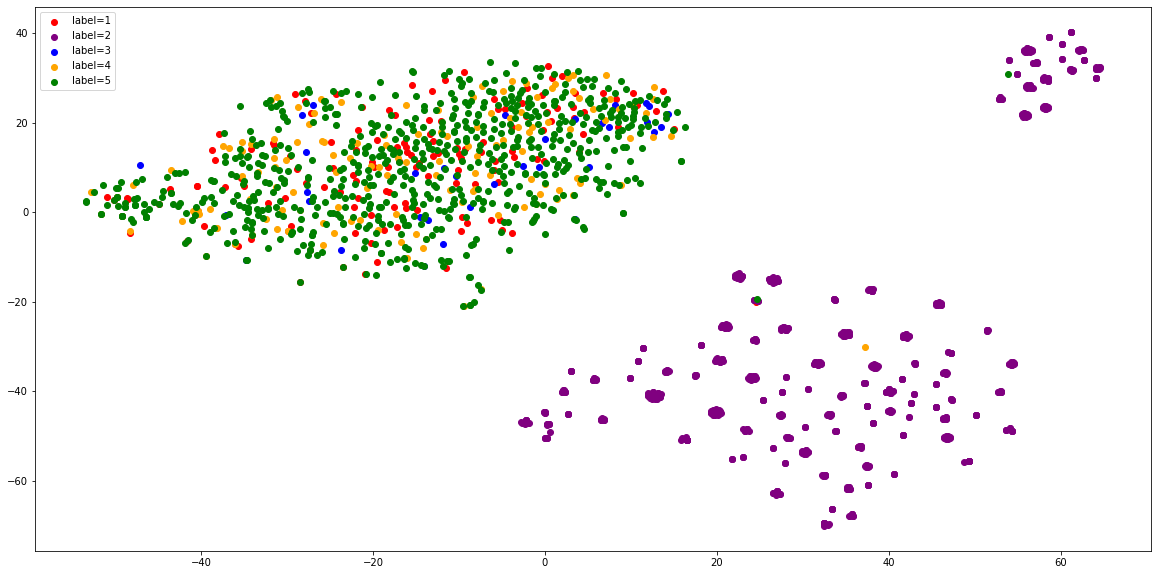

In [27]:
from sklearn.manifold import TSNE

plt.rcParams["figure.figsize"] = (20,10)

X_embedded = TSNE(n_components=2, random_state=123).fit_transform(embeddings)
for val, color in [(1, 'red'), (2, 'purple'), (3, 'blue'), (4, 'orange'), (5, 'green')]:
    idx = (X_test['ratings'].to_numpy() == val).nonzero()
    plt.scatter(X_embedded[idx, 0], X_embedded[idx, 1], c=color, label=f'label={val}')
plt.legend(loc='best')

This concludes the multiclass text classification walkthrough using AutoGluon.